In [1]:
import os, sys, json
from pprint import pprint

import numpy as np

from vis_samples import highlight_steps
from const import datasets, models, dataset_model_best_lr, LETTERS
from stats import make_stats, average_mass_shift, instance_changed_prediction
from util import load_results, filter_for_agreement, group_results, sort_key

In [2]:
def heatmap_instances(path_root, type="sentencize", method='npo_KL', rs=1001,
                   ff2=True, pos=True, do_print=False):
    results = {}
    for dataset in datasets:
        for model in models:
            lr = dataset_model_best_lr[dataset][model]
       
            floc = f'{path_root}/{dataset}/{model}/{method}_{type}_s=True_lr={lr}_rs={rs}_pos={pos}_ff2={ff2}.out'
            if not os.path.exists(floc):
                continue
    
            per_instance_results = load_results(floc)
            
            if per_instance_results:
                key = f"{dataset},{model},{method},{lr}"
                results[key] = per_instance_results
    return results

In [3]:
def compute_salient_steps(some_results):
    steps_causing_flip = {}
    steps_most_mass = {}
    
    for idx, (a_key, results) in enumerate(some_results.items()):
        d, m, _, _ = a_key.split(",")
        k_s = ' '.join([d,m])
        
        flipped = []
        
        for i, (q_key, q_results) in enumerate(results.items()):
            
            question = q_results[0]['question']    
            options = q_results[0]['options']
            steps = q_results[0]['segmented_cot']
            correct = LETTERS.index(q_results[0]['correct'])
            predicted = q_results[0]['prediction']
            
            salience_scores = [0] * len(q_results[0]['segmented_cot'])
            for unlearned_step in q_results:
                step_idx = unlearned_step['step_idx']
                mass = average_mass_shift(unlearned_step, do_print=False)
                salience_scores[step_idx] = mass
                step_results = unlearned_step['unlearning_results']
                has_flip, flips = instance_changed_prediction(step_results)
                flipped.append(has_flip)

            if not any(flipped) or max(salience_scores) < 0.1: continue

            highlight_steps(question, options, steps, correct, predicted, salience_scores)
            
            if i >= 2: break # Only plot two instances for each <dataset, model> combination
    
    return

In [4]:
unlearning_results = heatmap_instances("final_results", "sentencize", ff2=True, pos=True)

In [7]:
filtered_results = {}
for a_key, result in sorted(unlearning_results.items(), key=lambda t: sort_key(t[0])):
    dataset, model, _, _ = a_key.split(",")
    filtered_result = filter_for_agreement(result)
    filtered_results[a_key] = filtered_result
grouped_results = group_results(filtered_results)

## Plot the heatmaps

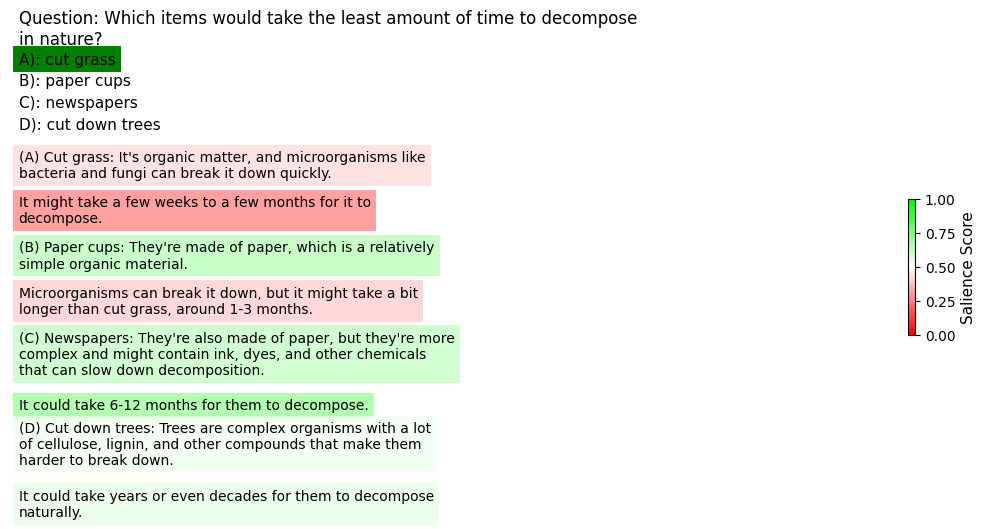

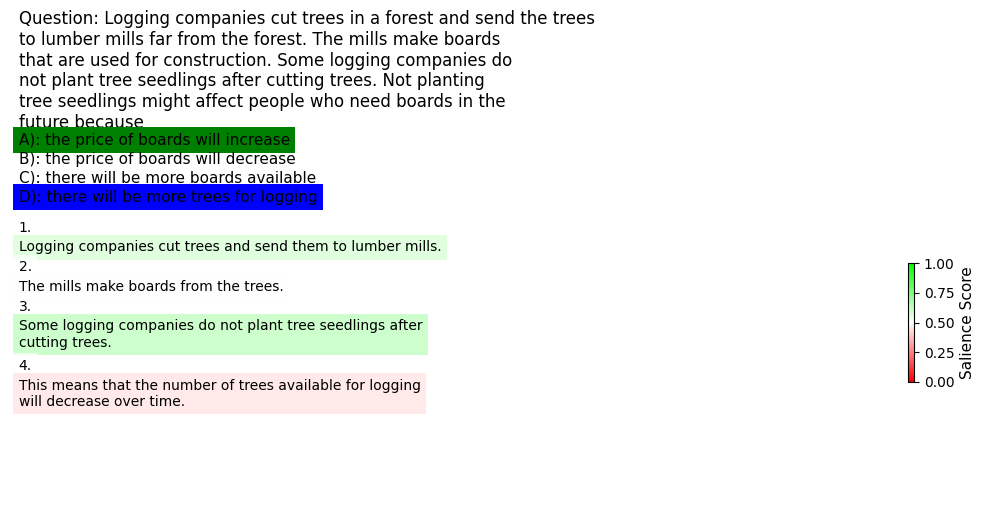

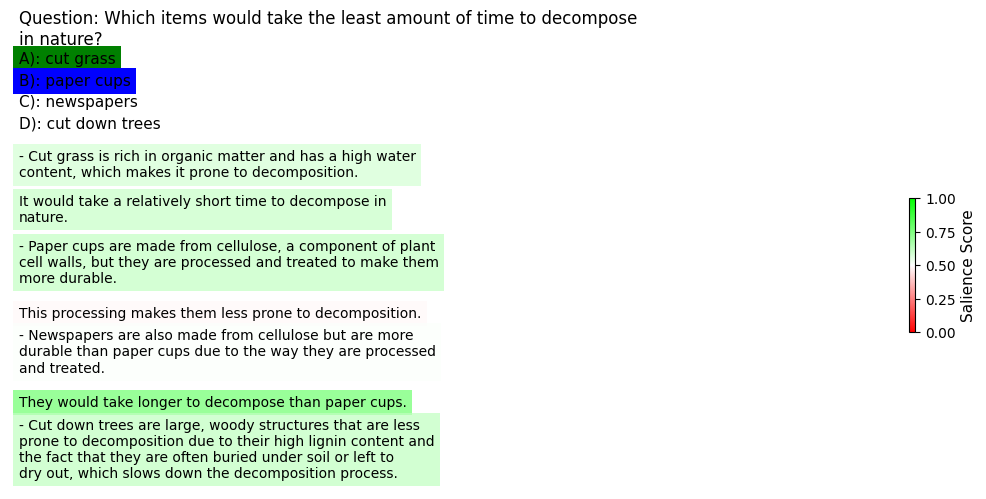

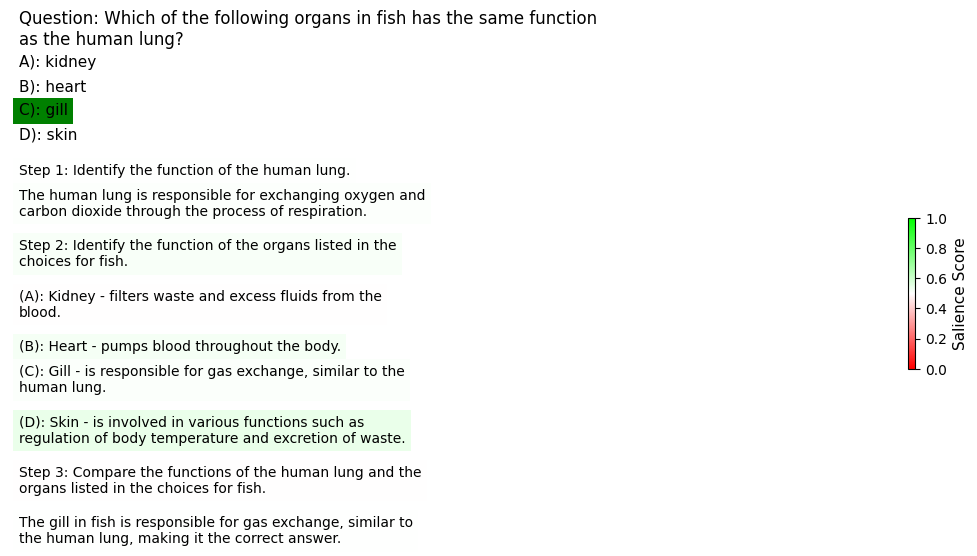

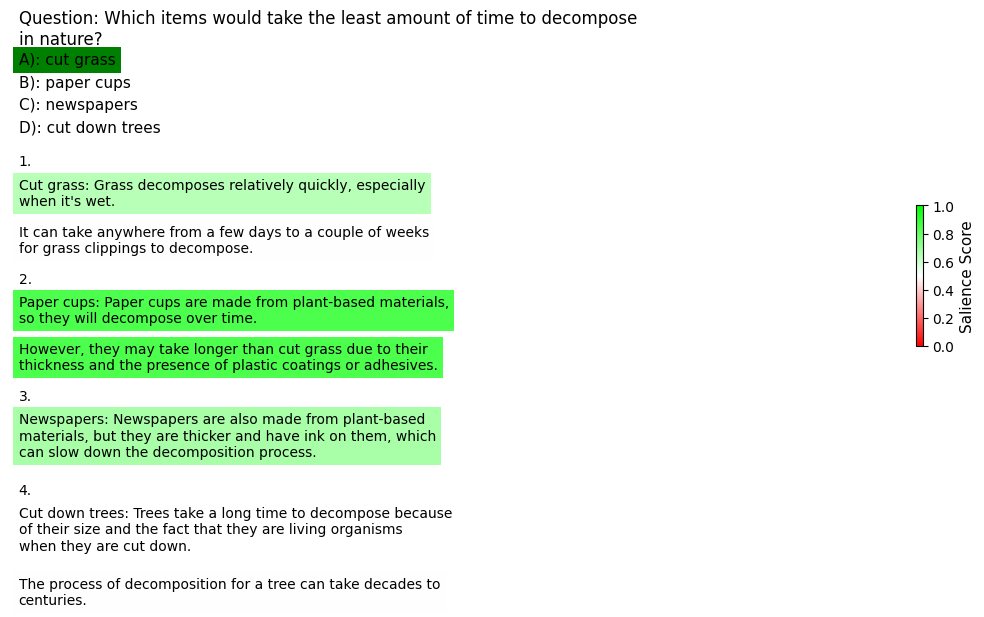

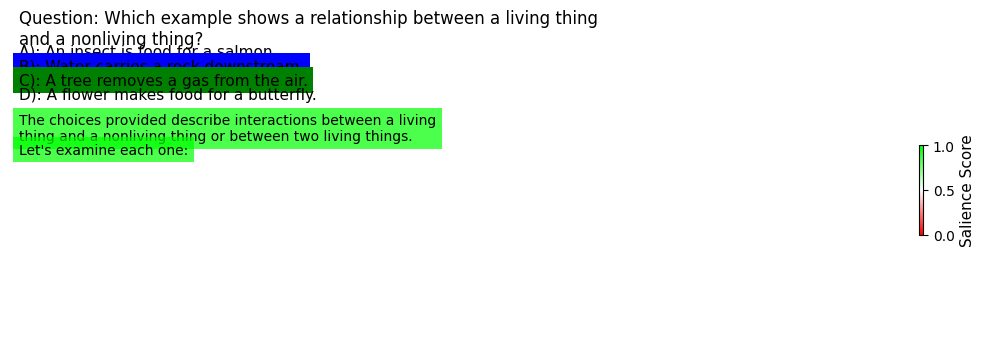

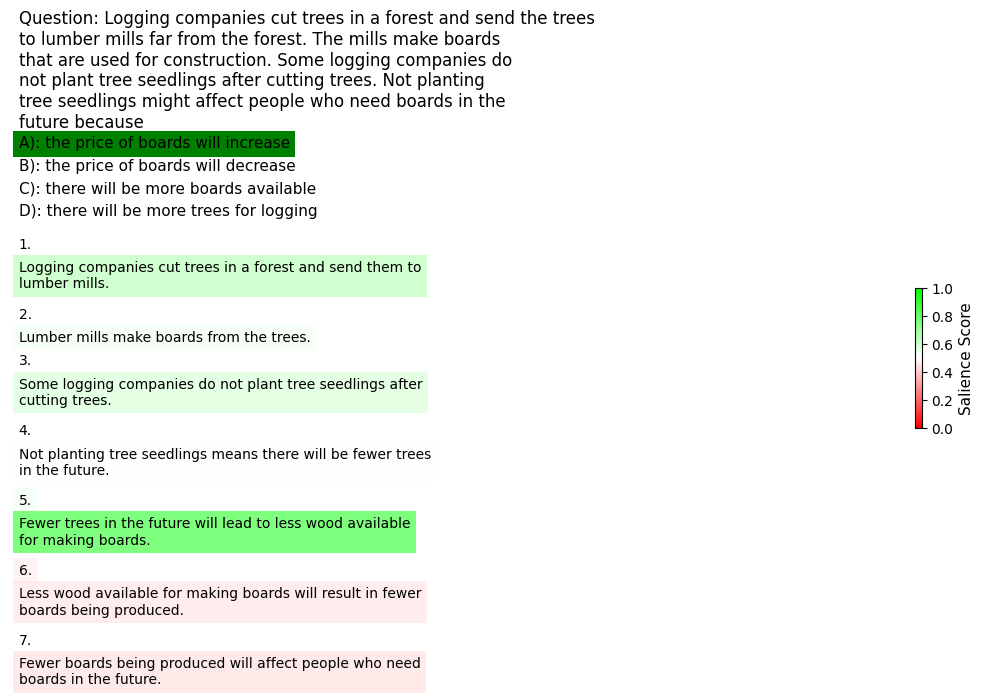

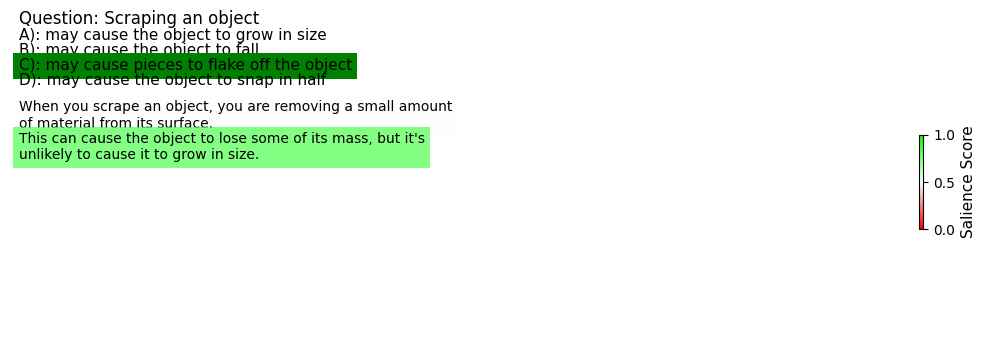

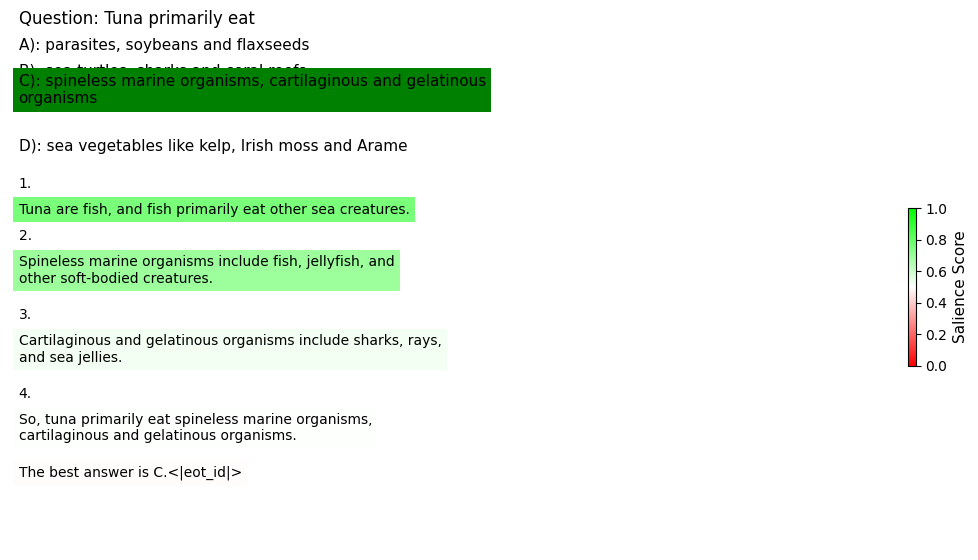

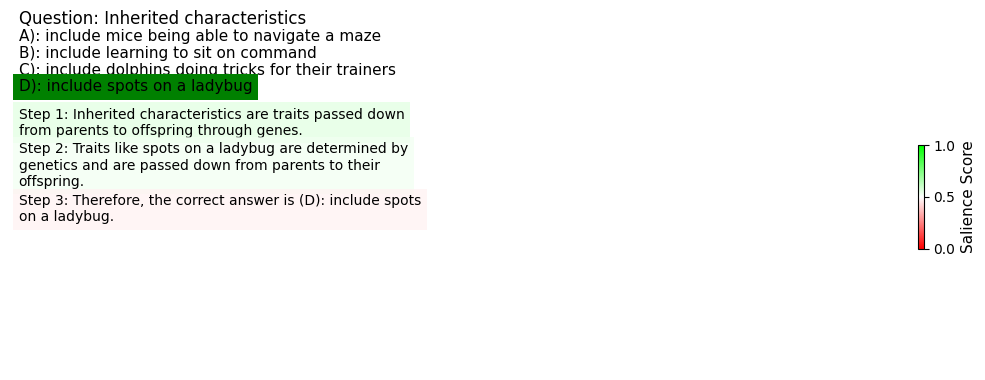

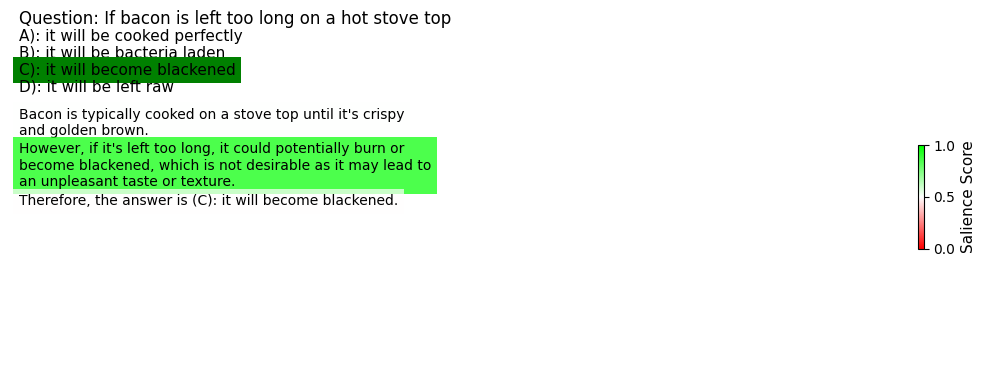

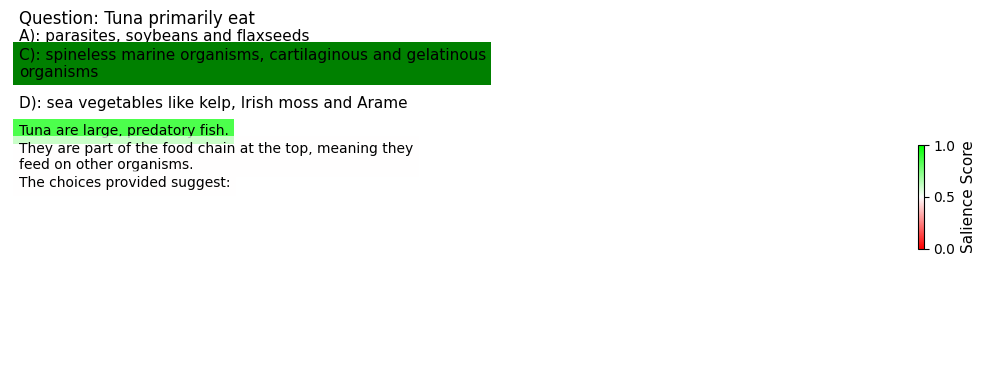

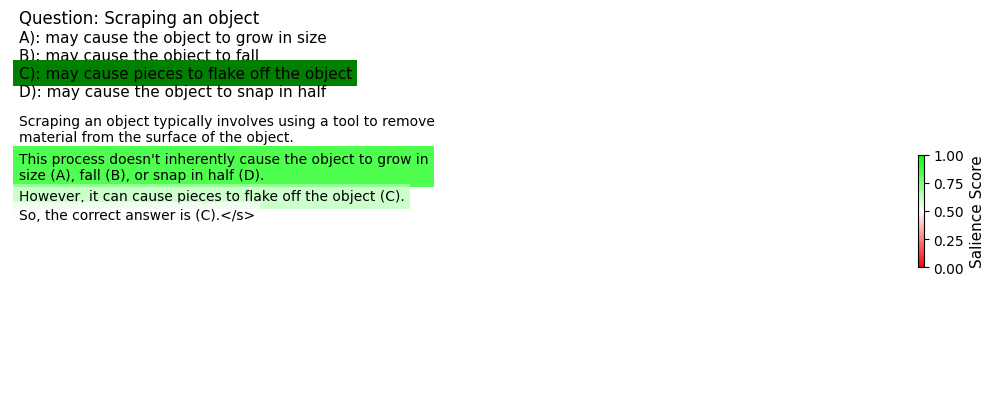

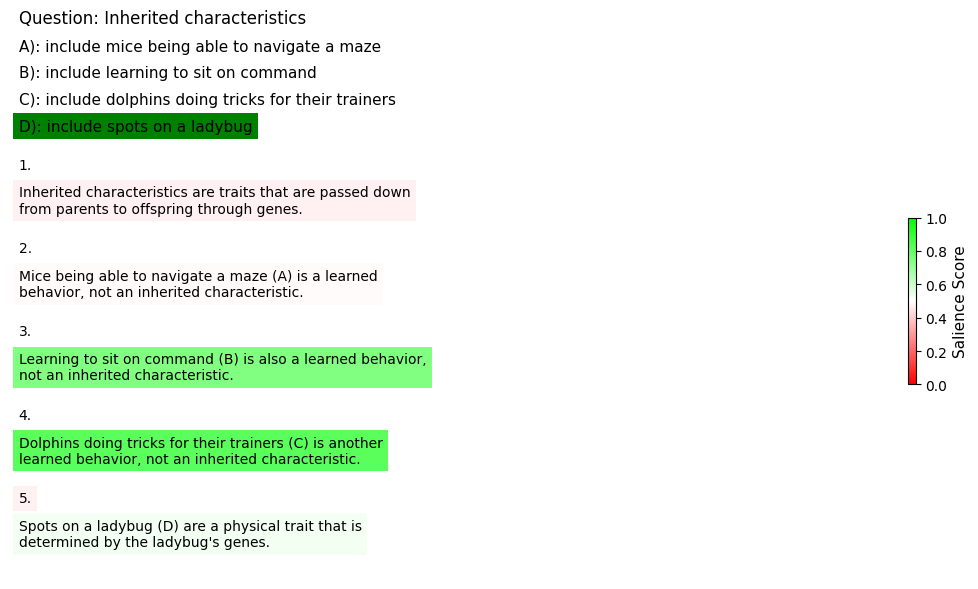

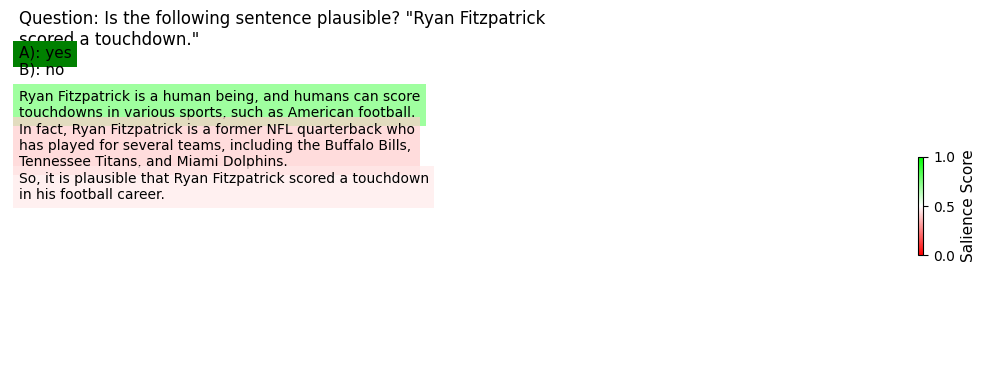

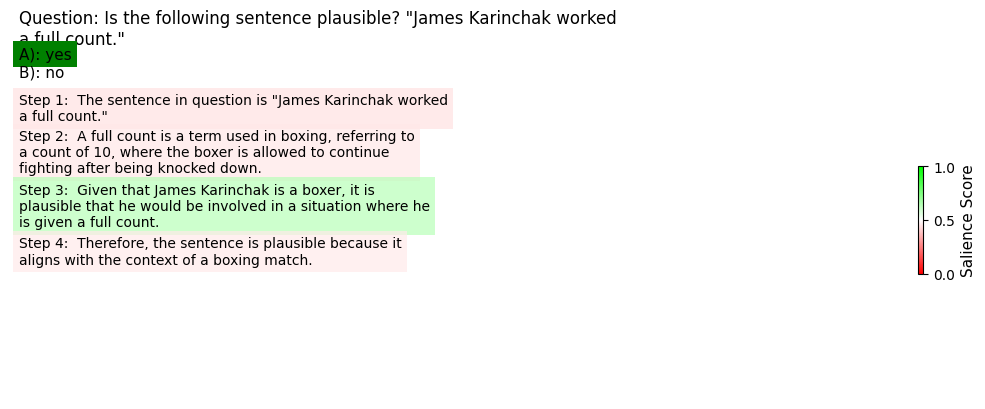

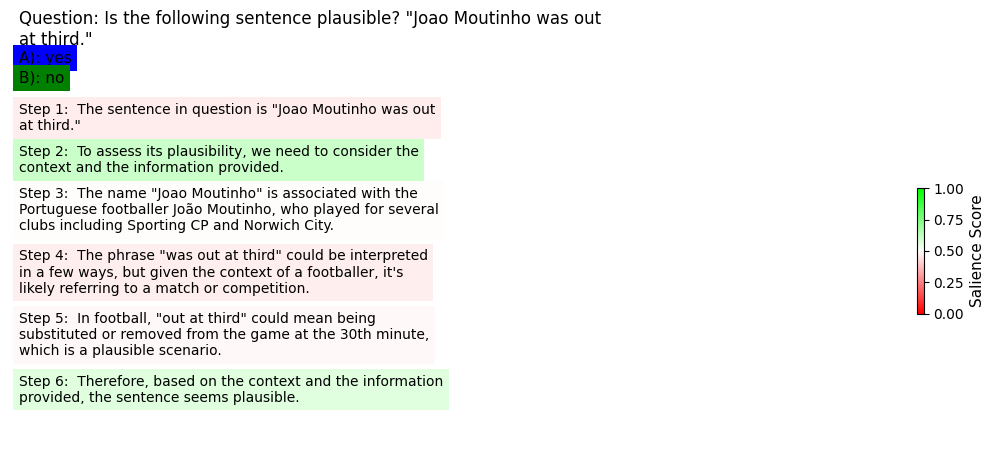

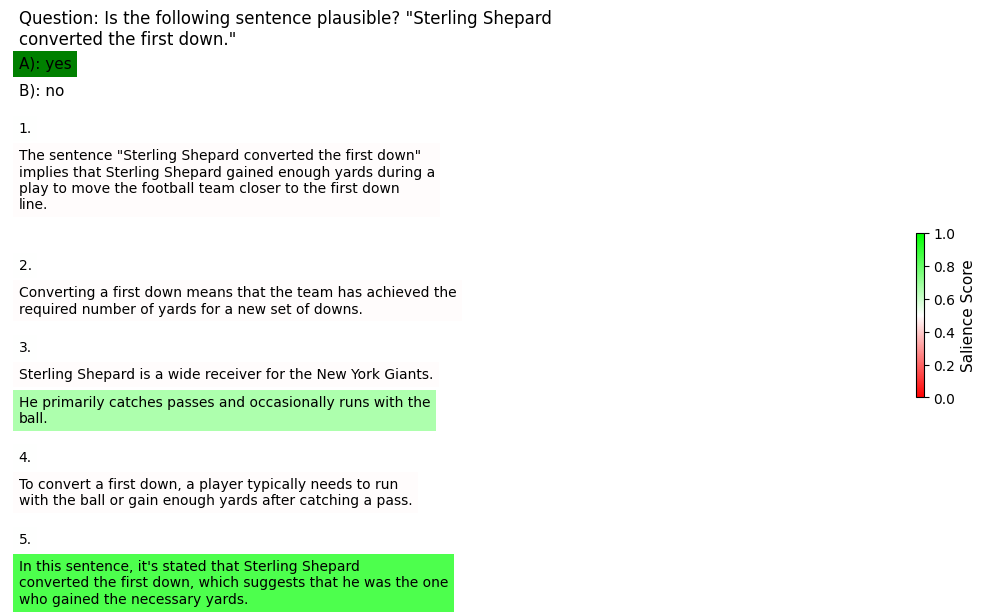

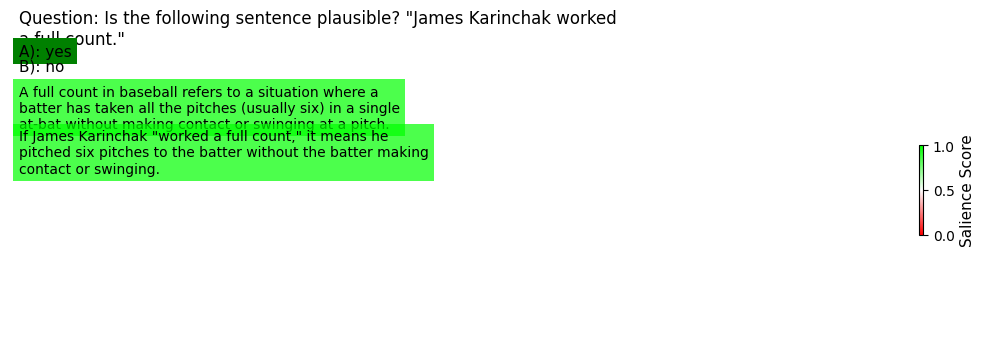

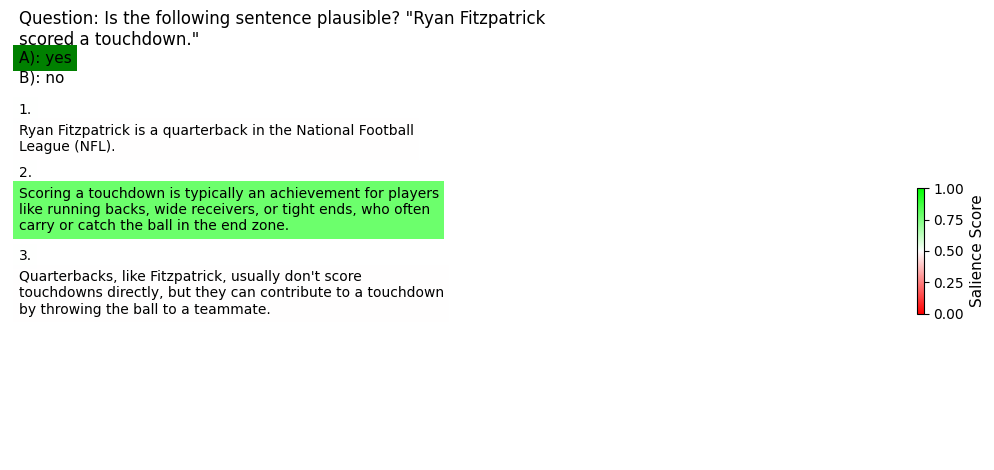

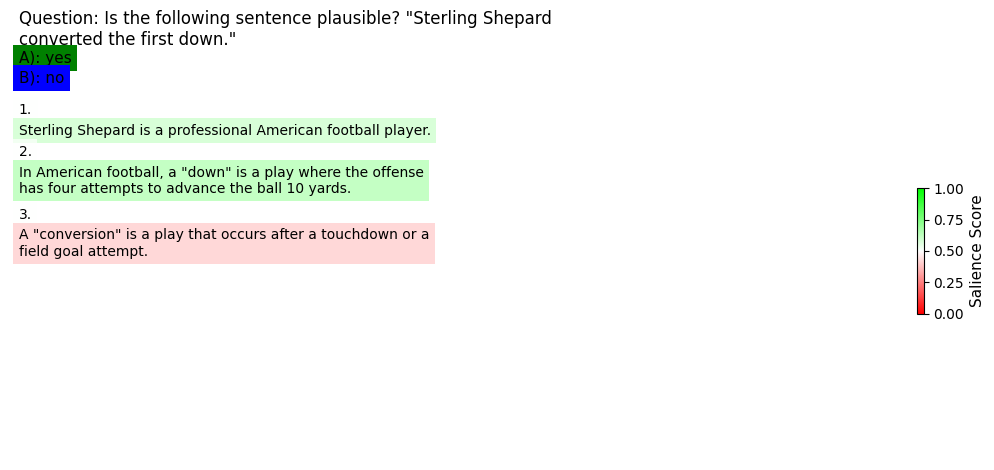

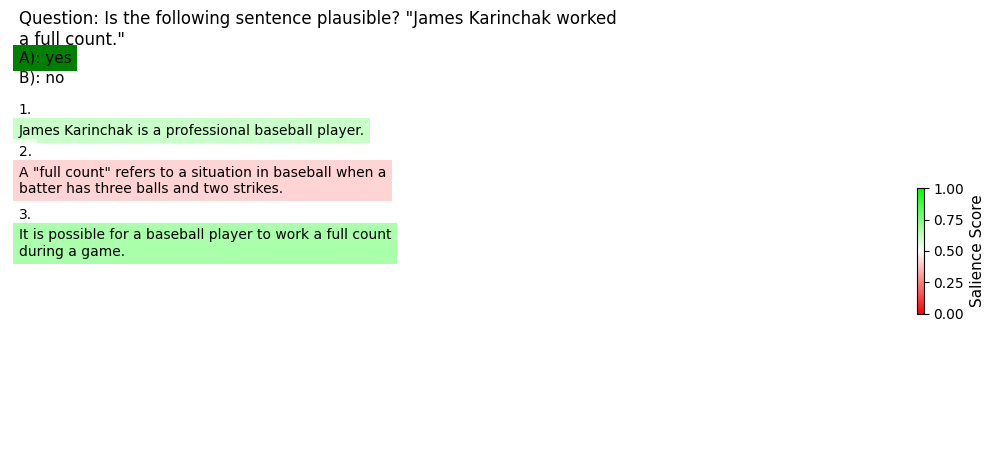

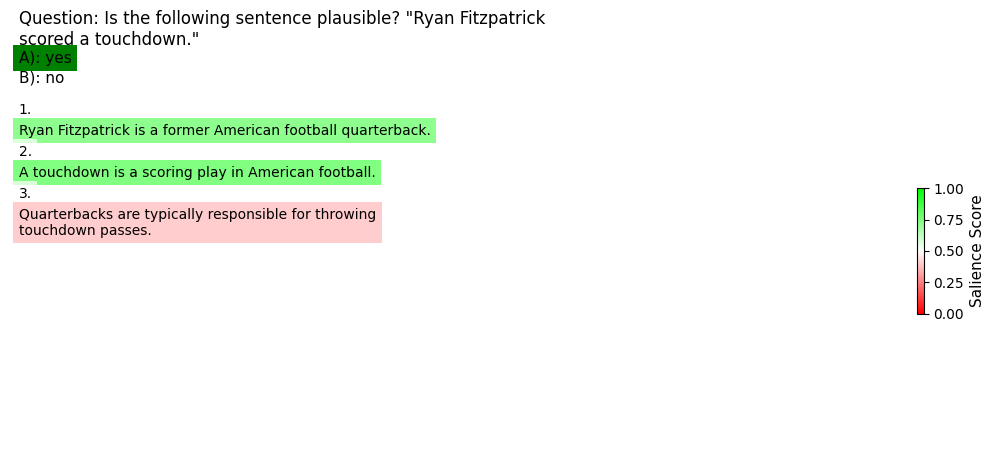

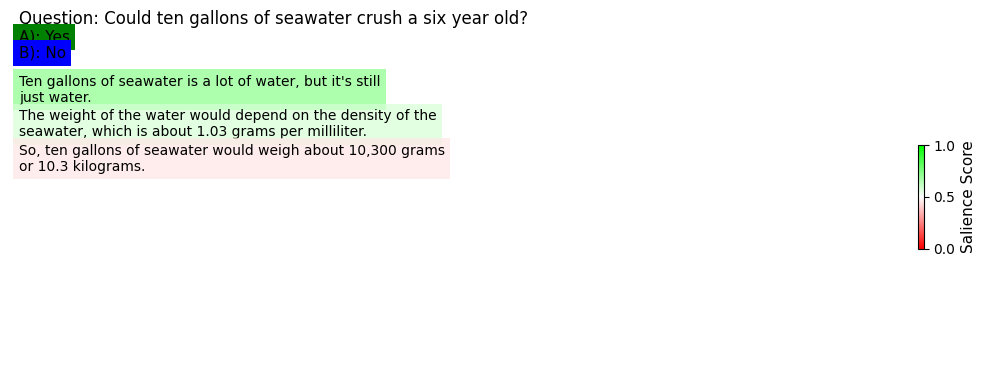

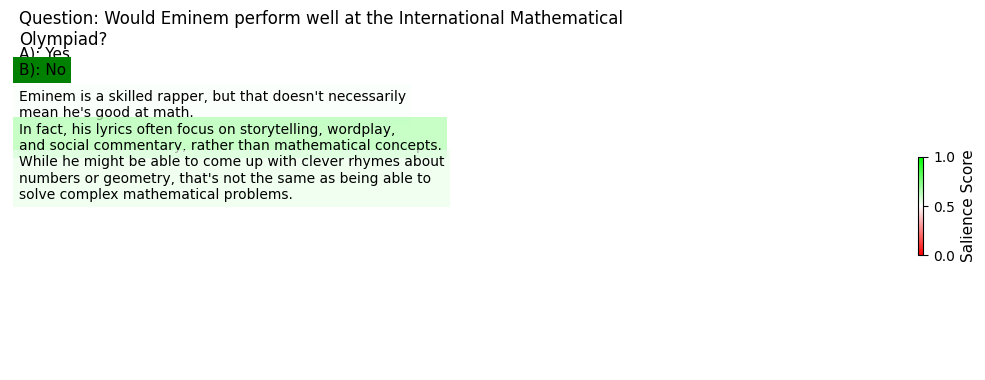

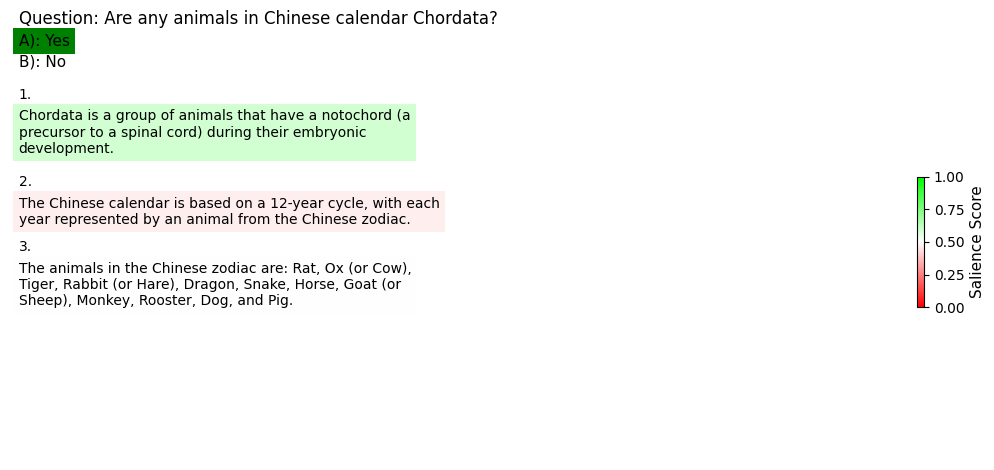

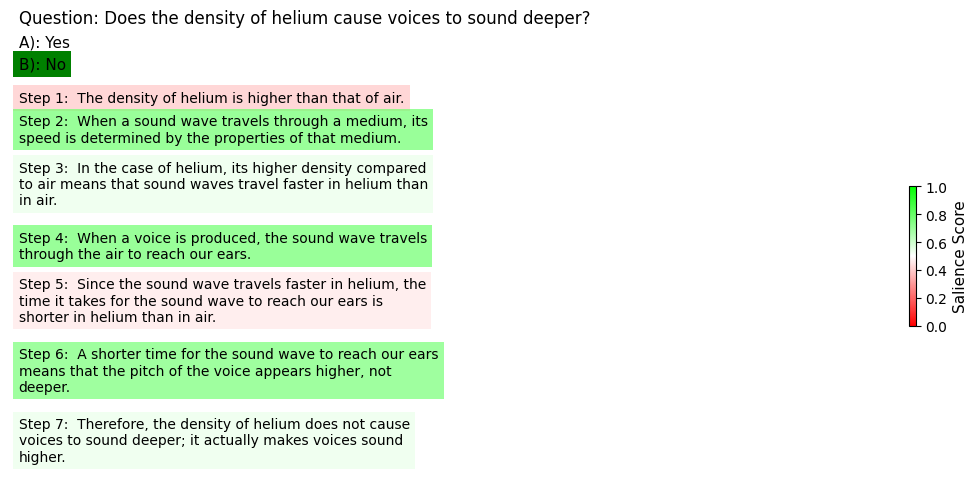

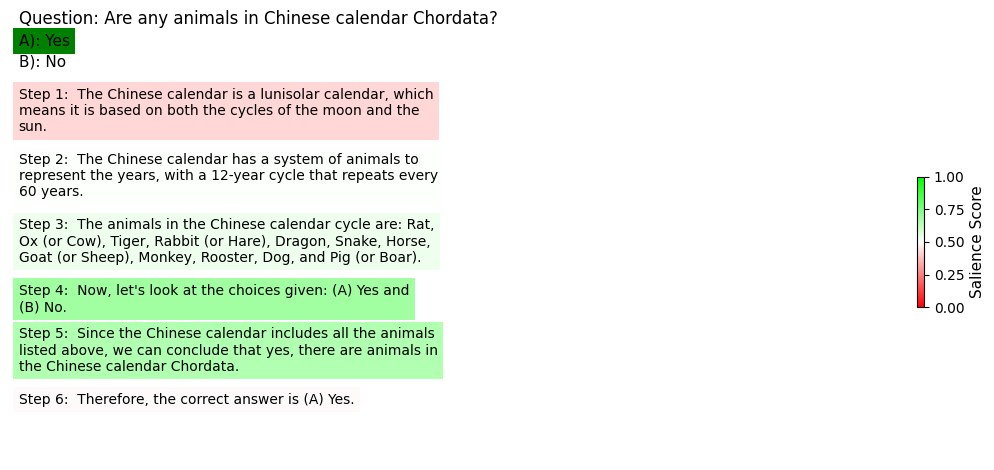

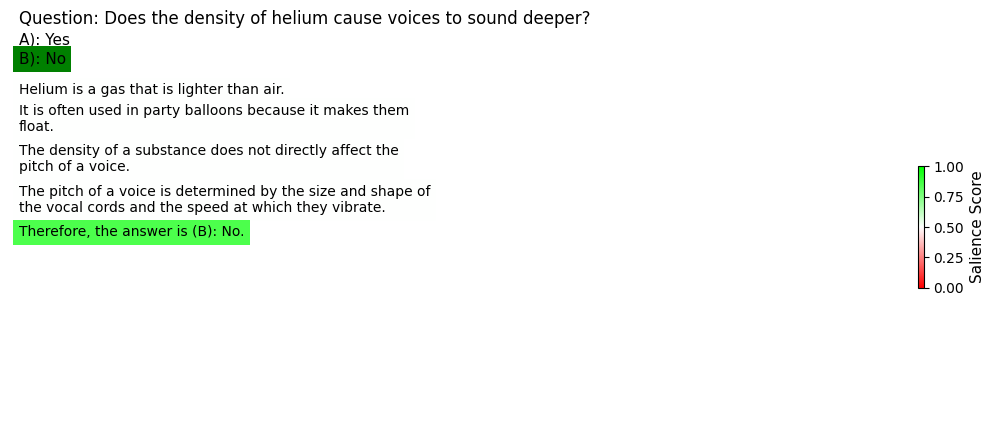

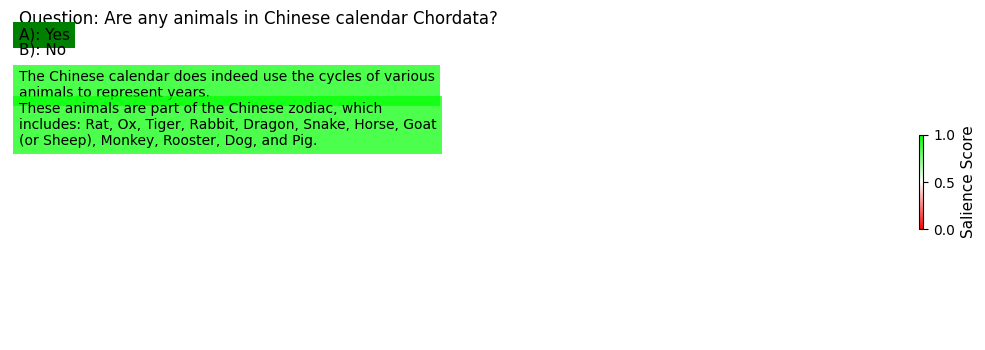

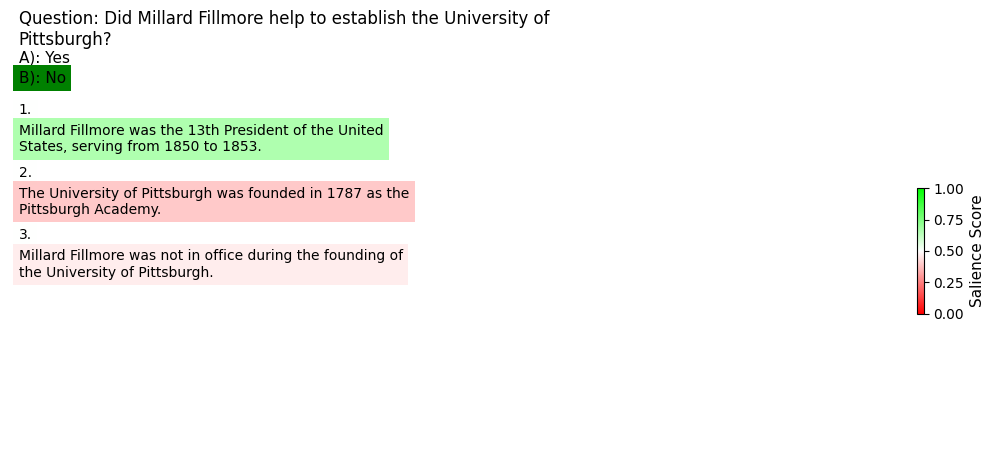

In [8]:
inst_data = compute_salient_steps(grouped_results)

## Plot the demo instance for the paper extra nicely

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

from matplotlib.colors import LinearSegmentedColormap
from textwrap import wrap

LETTERS = ['A', 'B', 'C', 'D', 'E']
# Define the colormap
red_to_green_cmap = LinearSegmentedColormap.from_list(
    "red_to_green", [(1, 0, 0), (1, 1, 1), (0, 1, 0)]  # Red to white to green
)

# Function to normalize and map values
def normalize_and_map(values, cmap, vmin=-1, vmax=1):
    norm = plt.Normalize(vmin, vmax)
    return [cmap(norm(val), alpha=0.7) for val in values]

def highlight_steps_paper_instance(question, options, reasoning_steps, correct, predicted, salience_scores, line_width=60):
    """
    Displays a question, answer options, reasoning steps, and highlights the text of steps based on salience.
    
    Args:
        question (str): The question text.
        options (list of str): List of answer options.
        reasoning_steps (list of str): List of reasoning steps.
        salience_scores (list of float): Salience scores for the reasoning steps, in the range [0, 1].
    """
    # Ensure salience_scores are normalized between 0 and 1
    assert len(reasoning_steps) == len(salience_scores), "Each reasoning step must have a salience score."
    plt.style.use('tableau-colorblind10')
    # Create a colormap for salience highlighting
    nb_colors = len(plt.rcParams['axes.prop_cycle'])
    cmap = plt.cm.Reds
    norm = mcolors.Normalize(vmin=0, vmax=1)
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(6, len(reasoning_steps) * 0.3 + 2))
    ax.axis('off')
    
    # Display the question
    y_pos = 1.0
    wrapped_question = "\n".join(wrap(question, 70))
    ax.text(0.01, y_pos, f"{wrapped_question}", fontsize=11, wrap=True, 
            bbox=dict(facecolor='None', edgecolor='k')) # , weight="bold"
    y_pos -= 0.11  # Move down slightly

    # Display answer options in a single row
    x_pos = 0.01
    col_width = 1.0 / len(options)  # Split the width evenly among columns
    for i, option in enumerate(options):
        option_lines = wrap(option, line_width)
        n_lines = len(option_lines)
        wrapped_option = "\n".join(option_lines)
        if i == correct:
            ax.text(
                0.01, y_pos, wrapped_option,
                fontsize=11, ha='left', wrap=True,
                bbox=dict(facecolor='forestgreen', edgecolor='k') # facecolor=mcolors.to_rgba('#006BA4') '006BA4'
            )
        elif i == predicted:
            ax.text(
                0.01, y_pos, wrapped_option,
                fontsize=11, ha='left', wrap=True,
                bbox=dict(facecolor='royalblue', edgecolor='k') # facecolor=mcolors.to_rgba('#CFCFCF')
            )
        else:
            ax.text(0.01, y_pos, wrapped_option, fontsize=11, ha="left", wrap=True)
        
        y_pos -= 0.09 * n_lines # Move down for each option

    salience_colors = normalize_and_map(salience_scores, red_to_green_cmap)

    anno_xs = [0.7, 0.79, 0.77, 0.75]
    # Display reasoning steps with text highlighting based on salience
    for i, (step, salience_color) in enumerate(zip(reasoning_steps, salience_colors)):
        step_lines = wrap(step, line_width)
        n_lines = len(step_lines)
        wrapped_step = "\n".join(step_lines)
        obj = ax.text(
            0.01, y_pos, wrapped_step,
            fontsize=10, va="top", wrap=True,
            bbox=dict(facecolor=salience_color, edgecolor='k', alpha=0.5) # , pad=0.5
        )
        ax.annotate(f'$\Delta$p={salience_scores[i]:.2f}', xy=(anno_xs[i], y_pos-0.060), xytext=(anno_xs[i]+0.1, y_pos-0.02),
                    # bbox=dict(facecolor='None', edgecolor='k'),
            arrowprops=dict(facecolor='black', shrink=0.02, linewidth=1),
            )
        y_pos -= 0.09*n_lines #- (i > 0) * 0.01) * n_lines   # Decrease vertical space between reasoning steps
        if i == 2: y_pos += 0.03
    plt.tight_layout()
    plt.savefig('figures/heatmap_sample.pdf', dpi=300)
    plt.show()


In [46]:
results_key = ','.join(['sqa','LLaMA-3','npo_KL', '1e-05'])
paper_instance_id = 'Can the Swiss Guard fill the Virginia General Assembly chairs?'
paper_instance_raw = grouped_results[results_key][paper_instance_id]

question = paper_instance_raw[0]['question']
options = paper_instance_raw[0]['options']
steps = paper_instance_raw[0]['segmented_cot']
correct = LETTERS.index(paper_instance_raw[0]['correct'])
predicted = paper_instance_raw[0]['prediction']

salience_scores = [0] * len(paper_instance_raw[0]['segmented_cot'])
for unlearned_step in paper_instance_raw:
    step_idx = unlearned_step['step_idx']
    mass = average_mass_shift(unlearned_step, do_print=False)
    salience_scores[step_idx] = mass
    step_results = unlearned_step['unlearning_results']
    has_flip, flips = instance_changed_prediction(step_results)

paper_instance_plot_data = (question, options, steps, correct, predicted, salience_scores)

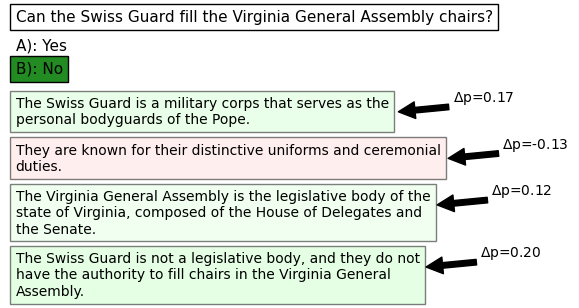

In [47]:
highlight_steps_paper_instance(*paper_instance_plot_data)